In [3]:
import os
import pickle
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import regularizers


In [19]:
# Step 1: Define Dataset Path and Labels
DATA_DIR = os.path.expanduser("~/Documents/gesture_data")  # macOS path
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Dataset folder not found: {DATA_DIR}")

class_labels = [chr(i) for i in range(65, 91)]  # A-Z labels
max_landmarks = 21  # Mediapipe hand landmarks

In [21]:
# Step 2: Initialize Mediapipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

I0000 00:00:1737995800.607713  273146 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1


In [23]:
# Step 3: Load and Process Dataset
data = []
labels = []

for dir_ in os.listdir(DATA_DIR):
    class_label = dir_  # Folder name is class label
    class_dir = os.path.join(DATA_DIR, dir_)

    if not os.path.isdir(class_dir):
        continue

    for img_path in os.listdir(class_dir):
        if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        img = cv2.imread(os.path.join(class_dir, img_path))
        if img is None:
            print(f"Skipping invalid image: {img_path}")
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            data_aux = []
            x_ = []
            y_ = []

            for hand_landmarks in results.multi_hand_landmarks:
                for lm in hand_landmarks.landmark:
                    x_.append(lm.x)
                    y_.append(lm.y)

                for lm in hand_landmarks.landmark:
                    data_aux.append(lm.x - min(x_))
                    data_aux.append(lm.y - min(y_))

            # Padding or trimming to max_landmarks * 2
            data_aux = data_aux[:max_landmarks * 2] + [0] * (max_landmarks * 2 - len(data_aux))
            data.append(data_aux)
            labels.append(class_label)

In [25]:
# Step 4: Save Processed Data as Pickle
with open('data.pickle', 'wb') as f:
    pickle.dump({'data': data, 'labels': labels}, f)

# Step 5: Load and Prepare Data for Training
with open('data.pickle', 'rb') as f:
    dataset = pickle.load(f)

data = np.array(dataset['data'])
labels = np.array(dataset['labels'])

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
data = data.reshape(-1, data.shape[1], 1, 1, 1)
data = data.astype('float32') / np.max(data)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [27]:
# Step 6: Build and Train the Model
model = Sequential([
    Conv3D(64, kernel_size=(3, 1, 1), activation='relu', input_shape=(data.shape[1], 1, 1, 1)),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 1, 1)),
    
    Conv3D(128, kernel_size=(3, 1, 1), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 1, 1)),
    
    Conv3D(256, kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.L2(0.001)),  # Extra layer with regularization
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    Dropout(0.4),
    Dense(len(lb.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test))

model.save('sign_language_model_1.keras')

Epoch 1/150


/Users/kavinraj/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4743 - loss: 2.8703 - val_accuracy: 0.0566 - val_loss: 4.1510
Epoch 2/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9197 - loss: 1.0381 - val_accuracy: 0.0606 - val_loss: 4.4901
Epoch 3/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9660 - loss: 0.8889 - val_accuracy: 0.0747 - val_loss: 5.2536
Epoch 4/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9738 - loss: 0.8363 - val_accuracy: 0.1010 - val_loss: 6.2495
Epoch 5/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9821 - loss: 0.7877 - val_accuracy: 0.0646 - val_loss: 6.2723
Epoch 6/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9814 - loss: 0.7545 - val_accuracy: 0.1677 - val_loss: 4.6155
Epoch 7/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9877 - loss: 0.6879 - val_accuracy: 0.3455 - val_loss: 3.6255
Epoch 8/150
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9905 - loss: 0.6533 - val_accuracy: 0.6222 - val_l

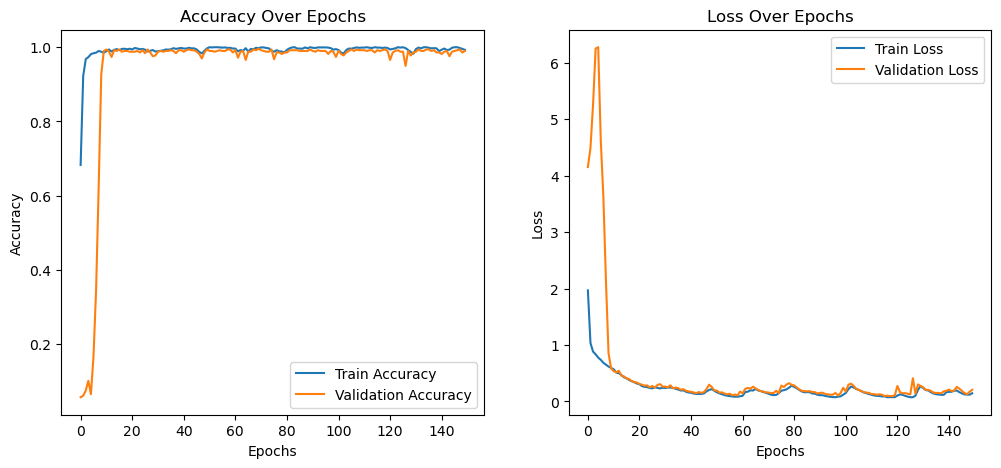

In [29]:
# Step 7: Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import pickle
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('sign_language_model_1.keras')

# Load label encoder
with open('data.pickle', 'rb') as f:
    dataset = pickle.load(f)
labels = sorted(list(set(dataset['labels'])))  # Labels from the dataset

# Initialize Mediapipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=False, min_detection_confidence=0.5, max_num_hands=1)

# Define maximum number of landmarks (for consistent input size)
max_landmarks = 21

# Start webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not access the camera.")
    exit()

print("Press 'q' to quit the webcam.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Extract landmarks
            x_ = [lm.x for lm in hand_landmarks.landmark]
            y_ = [lm.y for lm in hand_landmarks.landmark]
            data_aux = []

            for lm in hand_landmarks.landmark:
                data_aux.append(lm.x - min(x_))
                data_aux.append(lm.y - min(y_))

            # Padding or trimming
            data_aux = data_aux[:max_landmarks * 2] + [0] * (max_landmarks * 2 - len(data_aux))

            # Normalize the input data
            max_value = np.max(data_aux) if np.max(data_aux) != 0 else 1
            input_data = np.array(data_aux).reshape(1, len(data_aux), 1, 1, 1).astype('float32') / max_value

            # Predict gesture
            pred = model.predict(input_data)
            label_index = np.argmax(pred)
            label = labels[label_index]

            # Display prediction
            cv2.putText(frame, f'Prediction: {label}', (10, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Draw hand landmarks
            mp_drawing.draw_landmarks(
                frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )

    # Display frame
    cv2.imshow('Sign Language Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


I0000 00:00:1737996034.566452  273146 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737996034.576301  629462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737996034.584041  629462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Press 'q' to quit the webcam.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━